In [42]:
from chem_ocean.ocean_data import dataFetcher, water_column
from chem_ocean.ocean_plt import rawPlotter

In [43]:
from matplotlib.mlab import griddata
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import cm, rcParams

import seaborn as sns
%matplotlib inline

import pandas as pd
import numpy as np

axis_sz= 14
tick_sz= 14

In [44]:
# @todo: must fix the data import to accomodate multiple tracers
    # update: does using cluster_d, but not fully masked 
# @todo: add function for loading data into a dataframe (for seaborn)
    # update: fix cluster_d to have all columns reflect dropna masking will resolve this

In [116]:
# @todo: break these functions out into three separate functions
def ox_po4_convert(dataset, **kwargs):
    if max(dataset.cluster_d['oxygen'])<300:
        ox_convert = lambda x: x*44.661
        dataset.cluster_d['oxygen'] = ox_convert(dataset.cluster_d['oxygen'])

    OP = {'SAtl':182, 'NAtl':173, 'SO_CDW':177}
    po4_convert = lambda x,y: x + y/175
    if 'corrected_OP' in kwargs:
        po4_star_c = []
        po4_convert_corr = lambda x,y,z: x + y/OP[z]
        for ik in range(len(dataset.cluster_d['latitude'])):
            if dataset.cluster_d['labels'][ik] in OP:
                po4_star_c.append(po4_convert_corr(dataset.cluster_d['phosphate'][ik], dataset.cluster_d['oxygen'][ik], dataset.cluster_d['labels'][ik]))
            else:
                po4_star_c.append(po4_convert(dataset.cluster_d['phosphate'][ik], dataset.cluster_d['oxygen'][ik]))
        dataset.cluster_d['po4_star_c'] = np.asarray(po4_star_c, dtype=float)
    dataset.cluster_d['po4_star'] = po4_convert(dataset.cluster_d['phosphate'], dataset.cluster_d['oxygen'])
    return dataset

def label_lat_ranges(dataset):
    lat_range_d = {(90,-10):'NAtl', (-10, -50):'SAtl', (-50, -70):'SO_CDW', (-70,-90):'SO_shelf'}
    labels = []
    
    for lat in dataset.cluster_d['latitude']:
        for key in lat_range_d:
            if lat<=key[0] and lat>key[1]:
                labels.append(lat_range_d[key])
    dataset.cluster_d['labels']= labels
    
    return dataset

## Background & Problem

### Observed Tracers
As processes occur in the ocean, the concentration of chemical constituents change. For example, evaporation results in increased salinity, and cell building by organisms takes up dissolved phosphate from the surrounding water, driving down the phosphate concentration.  Salinity, and phosphate, in addition to nitrate, oxygen, and temperature (though a physical parameter of the ocean rather than a chemical), among many others, are referred to as "tracers" because when plotted out, they help oceanographers "trace" the paths of water and the processes occurring in the ocean. When a tracer concentration is  determined at the ocean surface at water formation and is distributed strictly by ocean circulation and mixing (viz. is unaffected by any additional biogeochemical processes), the tracers is considered “conservative.” Salinity, as well as certain CFCs present in the atmosphere that dissolve in surface water, are examples of conservative tracers. 

### PO<sub>4</sub>\*

The concentration of phosphate in the deep ocean reflects a combination of the amount of phosphate present in the water at the time of water formation, and the amount contributed by regenerated organic matter (phytoplankton that have died, sunk to some depth, and dissolved into constituent molecules).  In 1998, Broecker et al. published a paper suggesting the use of a calculated tracer, PO<sub>4</sub>\*, that reflected the concentration of preformed nutrients (the concentration present in the water at the time of water formation).  Their argument was that by correcting for the non-conservative contribution to PO<sub>4</sub>, PO<sub>4</sub>\* would act as a conservative tracer and therefore could be used to trace the relative contributions of different watermasses at a given location.

The formula they put forth was relatively simple:  
PO<sub>4</sub>\* =PO<sub>4</sub> + O<sub>2</sub>/175 -1.95  
(though the constant is a scaling factor and doesn't affect study of the relative differences in PO<sub>4</sub>\*)

where 175 is the global average moles of oxygen per molecule PO<sub>4</sub> needed to respire marine organic matter.  

Indeed, work in the late 1960s by Redfield et al., gave rise to a general notion that nutrients are taken up by phytoplankton in a suprisingly consistent ratio of carbon:nitrate:phosphate and generalized to the idea that a similarly consistent amount of oxygen would be consumed in the respiration of this organic matter post mortum....hence the 175 generalization.  While the so called "Redfield ratio" persists as a rule of thumb, there is a growing number of studies that suggest that the composition of phytoplankton populations vary by region (and therefore so too does the number moles of O<sub>2</sub> needed to respire said organic matter, viz. the O<sub>2</sub>/PO<sub>4</sub>).   

### Problem

PO$_4$\* is conceptually pleasing, but a recent paper by Rae and Broecker (2018) attempted to calculate the ratio of Southern Ocean to North Atlantic Deep Water in the Pacific based on PO$_4$\* and came up short when they compared their calculations to the numbers necessary to satisfy the salinity budget of the deep Pacific.  

## Hypothesis
I hypothesize that specifying the O<sub>2</sub>/PO$_4$ by region may improve the watermass fraction estimates generated using PO$_4$\* and bring them more in line with those calculated based on salinity. 

## Plan
#### World Ocean Atlas 2013
The World Ocean Atlas 2013 is an ocean data product produced by the Ocean Climate Laboratory and the National Oceanographic Data Center.  WOA fields include temperature, salinity, phosphate, nitrate, oxygen, silicic acid, among others and are reported at 1 degree resolution at 102 standard depth levels from surface to the abyssal floor (5500m). 

1.) Explore the relationship between nutrients in the Atlantic Ocean (seaborn pairplot)  
2.) Look into conservative nature of tracers (histograms)  
3.) Look into PO4*  (plot against PO4, salinity)
4.) Calculate whether the fractions for salinity are different from those for PO4*  
5.) Calculate whether the regional correction produces a difference  
6.) Analyze correction effect for lurking variables

In [46]:
tracers_psql = ['phosphate', 'oxygen', 'nitrate', 'salinity']
tracer_string = ','.join(tracers_psql)

In [47]:
dataset_Atl = dataFetcher()
dataset_Atl.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE longitude < 0 and longitude >-70 and latitude> -70 and depth >=3000'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')
dataset_Atl= ox_po4_convert(label_lat_ranges(dataset_Atl), corrected_OP= True)
df_Atl = pd.DataFrame(dataset_Atl.cluster_d)


In [48]:
dataset_SO = dataFetcher()
dataset_SO.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE latitude <= -70 and depth >=3000'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')
dataset_SO= ox_po4_convert(label_lat_ranges(dataset_SO), corrected_OP= True)
df_SO = pd.DataFrame(dataset_SO.cluster_d)


In [54]:
def concat(dataset1, dataset2):
    for key in dataset1.cluster_d.keys():
        dataset1.cluster_d[key] = np.concatenate((dataset1.cluster_d[key], dataset2.cluster_d[key]))
    dataset1._x = dataset1.cluster_d['longitude']
    dataset1._y = dataset1.cluster_d['latitude']     
    dataset1._d = dataset1.cluster_d['depth']                                            
    return dataset1

In [61]:
# key: ([min_lon, max_lon], [min_lat, max_lat])

ocean_parts = {'NNAtl':([-70,10],[60,90]),
               'NAtl': ([-70, -10],[60,0]),
               'SAtl': ([-70,20],[-50,0]),
               'Ind': ([20,90],[-50,10]),
               'Aus': ([90,150],[-50, -10]),
               'NPac_E': ([-180,-100],[0, 50]),
               'NPac_W': ([140, 180],[0, 50]),
               'SPac_E': ([-180, -70],[-50, 0]),
               'SPac_W': ([150, 180],[-50, 0])
                    }

In [63]:
dataset_globe = dataFetcher()
dataset_globe.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE latitude <= -70 and depth >=3000'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')
for key in ocean_parts.keys():
    ([min_lon, max_lon], [min_lat, max_lat]) = ocean_parts[key]
    dataset_new = dataFetcher()
    dataset_new.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE longitude < {} and longitude >{} and latitude <{} and latitude> {} and depth >=3000'.format(tracer_string, max_lon, min_lon, max_lat, min_lat),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')
    dataset_globe = concat(dataset_globe, dataset_new)


In [64]:
dataset_globe.cluster_d['labels'] = ['global' for ik in range(len(dataset_globe.cluster_d['latitude']))]
dataset_globe= ox_po4_convert(dataset_globe, corrected_OP= True)
df_globe = pd.DataFrame(dataset_globe.cluster_d)

In [12]:
# Global Ocean
dataset_globe = dataFetcher()

dataset_globe.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE depth >=3000 and salinity<38 and salinity>34.5'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')
dataset_globe.cluster_d['labels'] = ['global' for ik in range(len(dataset_globe.cluster_d['latitude']))]
dataset_globe= ox_po4_convert(dataset_globe, corrected_OP= True)
df_globe = pd.DataFrame(dataset_globe.cluster_d)

In [65]:
df_all = pd.concat([df_Atl,df_SO, df_globe])

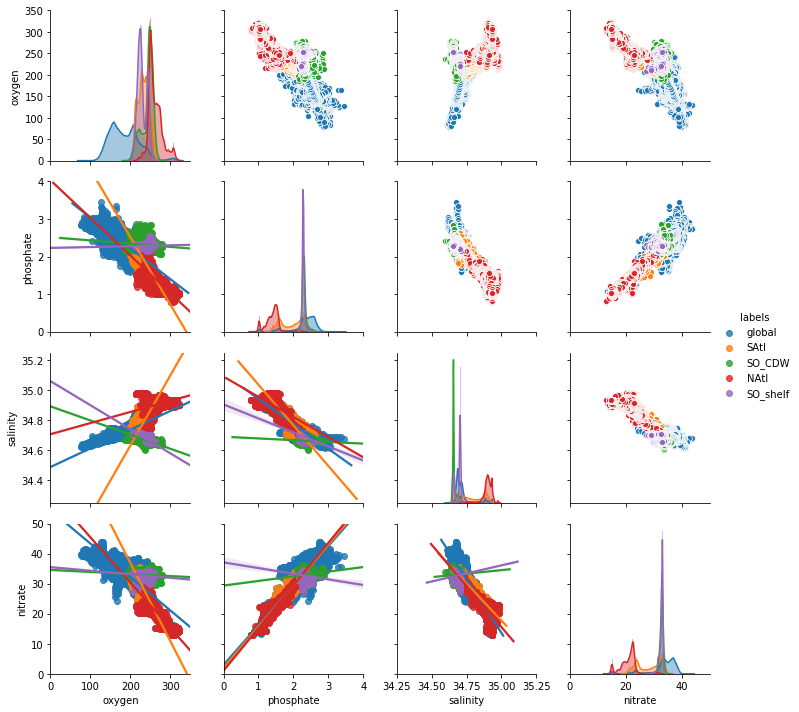

In [67]:
g = sns.PairGrid(df_all[['oxygen', 'phosphate', 'salinity', 'nitrate', 'labels']], diag_sharey=False, hue = 'labels', hue_order = ['global', 'SAtl', 'SO_CDW','NAtl','SO_shelf' ])
g.map_upper(sns.scatterplot)
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)

g.set(alpha=0.1)

g.axes[0,0].set_xlim(0,350)
g.axes[0,0].set_ylim(0,350)
g.axes[0,1].set_xlim(0,4)
g.axes[1,0].set_ylim(0,4)
g.axes[0,2].set_xlim(34.25,35.25)
g.axes[2,0].set_ylim(34.25,35.25)
g.axes[0,3].set_xlim(0,50)
g.axes[3,0].set_ylim(0,50)

g.add_legend()


The scatter plots above suggest that PO<sub>4</sub> has the tightest relationship to salinity.  Unlike nitrate and oxygen, [PO<sub>4</sub>] is not affected by additional processes besides uptake and release by organisms.  (Oxygen and nitrate are both oxidation agents in the respiration of organic matter, and the equilibration with the atmosphere also affects the concentration of oxygen in the surface ocean.) 

In [68]:
# High Latitude Atlantic
dataset_high_lat_Atl = dataFetcher()
dataset_high_lat_Atl.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE (longitude < 0 and longitude >-70) and (latitude >50 or latitude <-45) and depth >=2500'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')
dataset_high_lat_Atl= ox_po4_convert(dataset_high_lat_Atl)


High latitude Atlantic basin below 3000 m (dark), Atlantic below 3000m (medium), global ocean below 3000 m (light)


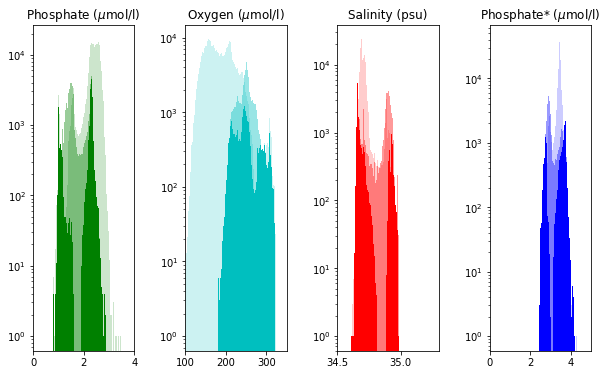

In [69]:
print('High latitude Atlantic basin below 3000 m (dark), Atlantic below 3000m (medium), global ocean below 3000 m (light)')
tracers = {'phosphate': ['Phosphate ($\mu$mol/l)', [0, 4], 'g'],
          'oxygen': ['Oxygen ($\mu$mol/l)', [100, 350], 'c'],
          'salinity': ['Salinity (psu)', [34.5, 35.3], 'r'],
          'po4_star': ['Phosphate* ($\mu$mol/l)', [0, 5], 'b']}

fig = plt.figure(figsize = (10,6))
gs = gridspec.GridSpec(1,len(tracers), width_ratios=np.ones(len(tracers)), wspace=0.5, hspace = 0.4) 
ax_out = []

for ik, tracer in enumerate(tracers):
    ax_out.append(fig.add_subplot(gs[ik]))
    n, bins, patches = ax_out[ik].hist(dataset_globe.cluster_d[tracer], 100, color = tracers[tracer][2], alpha = .2)
    n, bins, patches = ax_out[ik].hist(dataset_Atl.cluster_d[tracer], 100, color = tracers[tracer][2], alpha = .4)
    n, bins, patches = ax_out[ik].hist(dataset_high_lat_Atl.cluster_d[tracer], 100, color = tracers[tracer][2], alpha = 1)
    ax_out[ik].set_xlim(tracers[tracer][1])
    ax_out[ik].set_title(tracers[tracer][0])
    plt.yscale('log', nonposy='clip')

The above histograms provide evidence that, while the ranges of PO<sub>4</sub> and oxygen extend beyond the values of the high latiude Atlantic and therefore would not make suitable tracers for calculating the relative contributions of North Atlantic and Southern Ocean water at a given point, PO<sub>4</sub>\* and salinity do a fairly good job bounding their respective global distributions. 

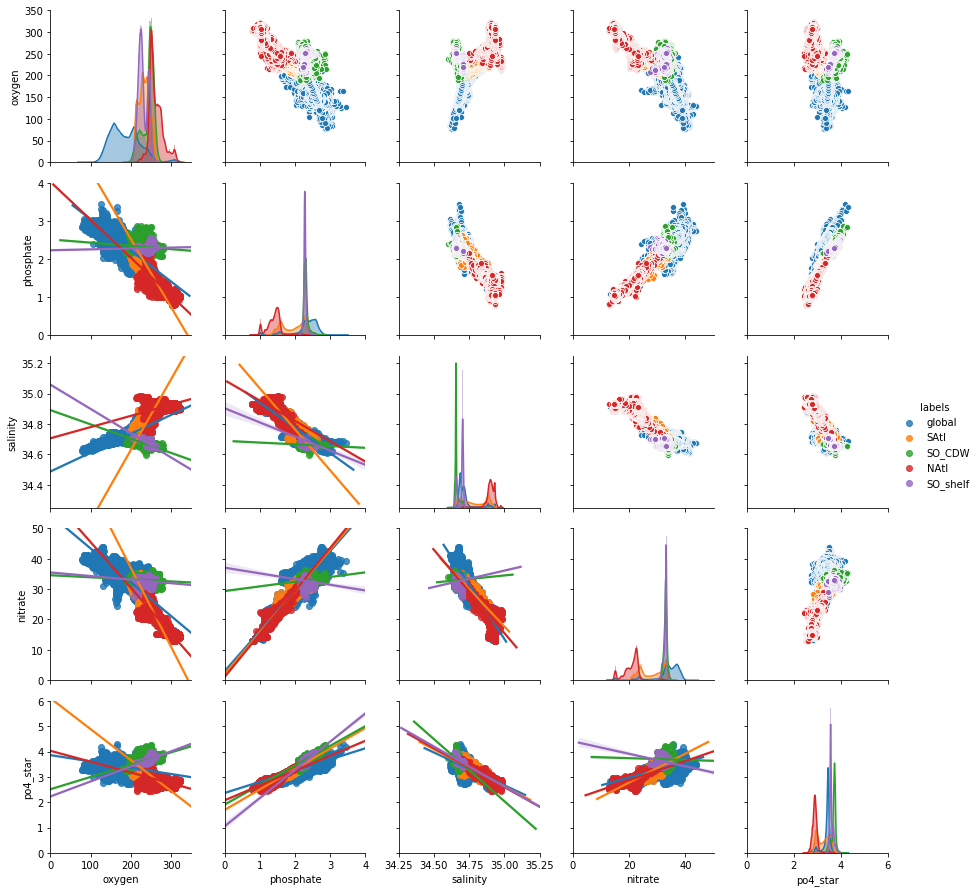

In [71]:
g = sns.PairGrid(df_all[['oxygen', 'phosphate', 'salinity', 'nitrate','po4_star', 'labels']], diag_sharey=False, hue = 'labels', hue_order = ['global', 'SAtl', 'SO_CDW','NAtl','SO_shelf' ])
g.map_upper(sns.scatterplot)
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)

g.set(alpha=0.1)

g.axes[0,0].set_xlim(0,350)
g.axes[0,0].set_ylim(0,350)
g.axes[0,1].set_xlim(0,4)
g.axes[1,0].set_ylim(0,4)
g.axes[0,2].set_xlim(34.25,35.25)
g.axes[2,0].set_ylim(34.25,35.25)
g.axes[0,3].set_xlim(0,50)
g.axes[3,0].set_ylim(0,50)
g.axes[0,4].set_xlim(0,6)
g.axes[4,0].set_ylim(0,6)

g.add_legend()

Looking at the pairplot again (this time with PO<sub>4</sub>\* added), we can see that phosphate better bounds the global ocean than PO<sub>4</sub>.  Additionally, looking at the regression lines in the phosphate-nitrate plot, the similarity of the slopes for the Atlantic and global ocean lend credibility to the notion that the composition of phytoplancton is relatively consistent.  

With PO<sub>4</sub>\* justified as a tracer, let's consider how effective it is for calculating watermass fraction.  Borrowing code from the previous capstone exercise, I propose to calculate watermass fraction based on both salnity and PO<sub>4</sub>\* and compare them with a paired t-test.  

Given recent studies suggest that phytoplankton differ in composition regionally, and therefore differ in the amount of oxygen consumed in the break down of dead organic matter, I also propose to use these regional corrections to calculate a "corrected PO<sub>4</sub>\*" and compare the efficacy to that of uncorrected PO<sub>4</sub>\*. 

In [106]:
def get_mixing_ratios(n_char, s_char, water_col):
    ax = water_col._ax_avgd
        
    ik = 0
    colors = [('r', 'b'), ('b', 'y'), ('y', 'm'), ('m', 'g'), ('g', 'c'),('c','k')]
    color = []
    depth = ax[0]
    
    mixing_ratios = [np.zeros(2) for ik in range(len(ax))]
    for ik in range(len(ax)):
        # fraction s_char
        mixing_ratios[ik][0] = max(min((water_col._feat_data_avgd[ik]-n_char)/(s_char-n_char), 1), 0)
        mixing_ratios[ik][1] = 1-mixing_ratios[ik][0]
        if mixing_ratios[ik][0] >= .5:
            color.append(colors[0][0])
        else:
            color.append(colors[0][1])
        ik+=1

    water_col.mixing_labels = color
    water_col.mixing_ratios = mixing_ratios
    water_col.n_char = n_char
    water_col.s_char = s_char


def updated_df(df, dataset):
    df_new = pd.DataFrame({ 'lat':dataset._ax_avgd, 
                            'value':dataset._feat_data_avgd,
                            'depth':[dpth for ik in range(len(dataset._feat_data_avgd))], 
                            'tracer' : [trcr for ik in range(len(dataset._feat_data_avgd))],
                            'mixing_fraction': [dataset.mixing_ratios[ik][0] for ik in range(len(dataset.mixing_ratios))]})
    df = pd.concat([df, df_new])
    return df

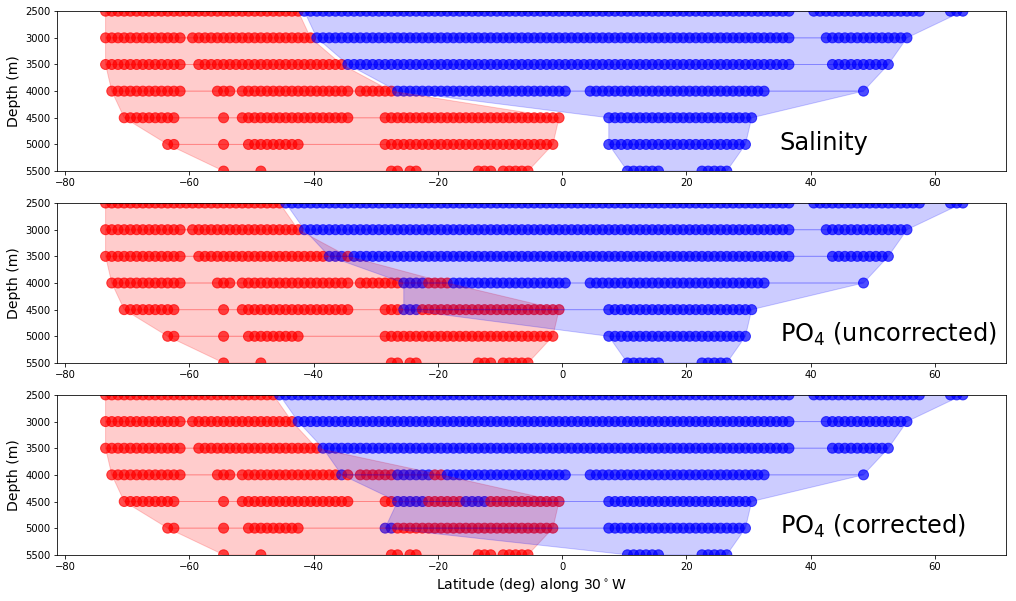

In [183]:
line_lon = -30
min_lat, max_lat = -80, 80

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(17, 10), facecolor='w')

tracers = ['salinity', 'phosphate', 'oxygen']
datast = dataFetcher()
datast.get_section('NS_section', line_lon, [min_lat, max_lat], tracers)
datast = ox_po4_convert(label_lat_ranges(datast))
datast = ox_po4_convert(datast,corrected_OP = True )

depths = [2500, 3000, 3500, 4000, 4500, 5000, 5500]
depth_traj = {}
df_mixing_ratios = pd.DataFrame({'lat':[], 'depth':[], 'mixing_fraction':[], 'tracer': [], 'value':[]})

tracers = ['salinity', 'po4_star', 'po4_star_c']
#add data into dataframe join on latitude
for im, trcr in enumerate(tracers):
    r = []
    b = []
    d_traj = {}
    for ij, dpth in enumerate(depths):
        Atl = water_column(datast, 'traj', depth= dpth, tracer=trcr)
        Atl.get_endmembers('two_endmember')
        get_mixing_ratios(Atl.n_char, Atl.s_char, Atl)
        d_traj[dpth] = Atl
        ax[im].scatter(Atl._ax_avgd, [dpth for ik in range(len(Atl._feat_data_avgd))], c = Atl.mixing_labels, alpha = .7, s=100)
        ax[im].set_ylim([6000,2000])
        df_mixing_ratios = updated_df(df_mixing_ratios, Atl)
        # create lists of latitudes where there are red points and blue points
        x_int_r = []
        x_int_b = []
        for ip in range(len(Atl._feat_data_avgd)):
            if Atl.mixing_labels[ip] == 'r':
                x_int_r.append(Atl._ax_avgd[ip])
            else:
                x_int_b.append(Atl._ax_avgd[ip])

        # create lists of bounding points for each depth
        r.append([dpth, x_int_r[0], x_int_r[-1]])
        b.append([dpth, x_int_b[0], x_int_b[-1]])

    ### fill code
    r_pairs = [[r[n-1], r[n]] for n in range(1,len(r))]
    b_pairs = [[b[n-1], b[n]] for n in range(1,len(b))]

    pair_sets = {'r':[r_pairs, []], 'b':[b_pairs,[]]}

    for color in pair_sets.keys():
        for pair in pair_sets[color][0]:
            ul = [pair[0][1], pair[0][0]]
            ur = [pair[0][2], pair[0][0]]
            ll = [pair[1][1], pair[1][0]]
            lr = [pair[1][2], pair[1][0]]

            xs = [ik[0] for ik in [ll, ul, ur, lr]]
            ys = [ik[1] for ik in [ll, ul, ur, lr]]

            pair_sets[color][1].append([xs, ys])

        for d in pair_sets[color][1]:
            ax[im].fill(d[0],d[1], c=color, alpha=.2)

    ax[im].set_ylim([5500, 2500])

    ax[im].set_ylabel('Depth (m)', fontsize=axis_sz)
    ax[im].set_xlabel('Latitude (deg) along {}$^\circ$W'.format(-line_lon), fontsize=axis_sz)

    # set tick parameters
    xtickNames = ax[im].get_xticklabels()
    ytickNames = ax[im].get_yticklabels()

    for names in [ytickNames, xtickNames]:
        plt.setp(names, rotation=0, fontsize=tick_sz-4) 
    
    depth_traj[trcr] = d_traj

ax[0].xaxis.label.set_visible(False)
ax[1].xaxis.label.set_visible(False)

ax[0].text(35, 5100, 'Salinity', color='k', size=24)
ax[1].text(35, 5100, 'PO$_4$ (uncorrected)', color='k', size=24)
ax[2].text(35, 5100, 'PO$_4$ (corrected)', color='k', size=24)

# name1 = 'two_endmember_Atlantic'
# path = 'raw_demo_plots/connectedness/'
# plt.savefig(path+name1+'.png', dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.2,
#         frameon=None)



In [118]:
df_mixing_ratios[['depth', 'value','tracer', 'mixing_fraction']].groupby(['depth', 'tracer']).describe()

mixing_fraction                                     \
                            count      mean       std  min       25%   
depth  tracer                                                          
2500.0 po4_star             132.0  0.326210  0.298826  0.0  0.163211   
       po4_star_c           132.0  0.311563  0.302618  0.0  0.110775   
       salinity             132.0  0.334853  0.333338 -0.0  0.123426   
3000.0 po4_star             124.0  0.356257  0.306542  0.0  0.180746   
       po4_star_c           124.0  0.340800  0.310726  0.0  0.137710   
       salinity             124.0  0.335355  0.356817 -0.0  0.090483   
3500.0 po4_star             119.0  0.392713  0.309514  0.0  0.195084   
       po4_star_c           119.0  0.377719  0.310811  0.0  0.156840   
       salinity             119.0  0.377293  0.357489 -0.0  0.118763   
4000.0 po4_star              97.0  0.541427  0.224567  0.0  0.366252   
       po4_star_c            97.0  0.530746  0.219987  0.0  0.374532   
       salinity              97.0  0.458676  0.362416 -0.0  0.080504   
4500.0 po4_star              81.0  0.508926  0.328323  0.0  0.082837   
       po4_star_c            81.0  0.487706  0.318716  0.0  0.086114   
       salinity              81.0  0.544627  0.366717 -0.0  0.039223   
5000.0 po4_star              63.0  0.490448  0.309338  0.0  0.140643   
       po4_star_c            63.0  0.473747  0.295905  0.0  0.146247   
       salinity              63.0  0.516974  0.381694 -0.0  0.041945   
5500.0 po4_star              25.0  0.458352  0.303754  0.0  0.158324   
       po4_star_c            25.0  0.450209  0.293862  0.0  0.164525   
       salinity              25.0  0.496854  0.422623 -0.0  0.043485   

                                            value                       \
                        50%       75%  max  count       mean       std   
depth  tracer                                                            
2500.0 po4_star    0.207800  0.326659  1.0  132.0   3.005396  0.326871   
       po4_star_c  0.193332  0.275156  1.0  132.0   2.996195  0.321103   
       salinity    0.167092  0.477621  1.0  132.0  34.875699  0.111221   
3000.0 po4_star    0.215789  0.492011  1.0  124.0   3.042391  0.330019   
       po4_star_c  0.214144  0.446490  1.0  124.0   3.031516  0.324412   
       salinity    0.140832  0.600956  1.0  124.0  34.859978  0.107806   
3500.0 po4_star    0.233405  0.621330  1.0  119.0   3.098233  0.330009   
       po4_star_c  0.229328  0.580322  1.0  119.0   3.086476  0.321305   
       salinity    0.160027  0.753065  1.0  119.0  34.836796  0.104941   
4000.0 po4_star    0.477698  0.708859  1.0   97.0   3.219154  0.322321   
       po4_star_c  0.458402  0.679768  1.0   97.0   3.203237  0.308630   
       salinity    0.328158  0.853820  1.0   97.0  34.795916  0.094644   
4500.0 po4_star    0.577806  0.782944  1.0   81.0   3.359835  0.277863   
       po4_star_c  0.558951  0.732235  1.0   81.0   3.342389  0.259163   
       salinity    0.614346  0.882212  1.0   81.0  34.760012  0.091453   
5000.0 po4_star    0.653252  0.700744  1.0   63.0   3.341944  0.285324   
       po4_star_c  0.612428  0.688316  1.0   63.0   3.327287  0.263290   
       salinity    0.732641  0.761806  1.0   63.0  34.764757  0.092619   
5500.0 po4_star    0.640018  0.688239  1.0   25.0   3.304491  0.291234   
       po4_star_c  0.592542  0.695822  1.0   25.0   3.298295  0.272279   
       salinity    0.832008  0.842912  1.0   25.0  34.778004  0.096850   

                                                                          
                         min        25%        50%        75%        max  
depth  tracer                                                             
2500.0 po4_star     2.648572   2.827100   2.875874   3.005888   3.742420  
       po4_star_c   2.665601   2.783143   2.870742   2.957564   3.726686  
       salinity    34.653767  34.828063  34.931674  34.946244  34.987426  
3000.0 po4_star     2.658850   2.853439   2.891165   3.188542 

In [119]:
# dictionaries by depth of mixing ratios for each tracer
sal_f = {key: np.asarray([depth_traj['salinity'][key].mixing_ratios[ik][0] for ik in range(len(depth_traj['salinity'][key].mixing_ratios))]) for key in depth_traj['salinity']}
po4_f = {key: np.asarray([depth_traj['po4_star'][key].mixing_ratios[ik][0] for ik in range(len(depth_traj['po4_star'][key].mixing_ratios))]) for key in depth_traj['po4_star']}       
po4_c_f = {key: np.asarray([depth_traj['po4_star_c'][key].mixing_ratios[ik][0] for ik in range(len(depth_traj['po4_star_c'][key].mixing_ratios))]) for key in depth_traj['po4_star_c']}       


In [120]:
# comparing salinity fractions with PO4 fractions (uncorrected, corrected)
import scipy.stats as stats
print('depth', ' t (uncorr)','\t', 'p (uncorr)', '\t \t |','t (corr)','\t\t', 'p (corr)' )
for key in sal_f:
#     uncorrected_diff = sal_f[key]-po4_f[key]
#     corrected_diff = sal_f[key]-po4_c_f[key]
    tval,pval=stats.ttest_ind(sal_f[key], 
                          po4_f[key],
                          equal_var=True)
    tval1,pval1=stats.ttest_ind(sal_f[key], 
                          po4_c_f[key],
                          equal_var=True)
    print(key, ':', tval,'\t', pval, '\t |',tval1,'\t', pval1 )


depth  t (uncorr) 	 p (uncorr) 	 	 | t (corr) 		 p (corr)
2500 : 0.221813262823 	 0.824632047087 	 | 0.594348087933 	 0.552792193064
3000 : -0.494794760023 	 0.621186616779 	 | -0.128142111132 	 0.898141204488
3500 : -0.355734515297 	 0.722357160897 	 | -0.00981270783632 	 0.992179007411
4000 : -1.91157336545 	 0.0574201329745 	 | -1.6742244607 	 0.0957146625967
4500 : 0.652775360515 	 0.514837933223 	 | 1.05439156121 	 0.293293288668
5000 : 0.428544215568 	 0.668998455172 	 | 0.710426000322 	 0.478774013879
5500 : 0.369881109871 	 0.713098088265 	 | 0.453084705307 	 0.652529301116


The correction seems to improve the alignment between fractions below 2500m and above 4500m. This might be because organic matter sinking from the surface and regenerating does so below 2500m, therefore making the correction inappropriate in the upper part of the water column.  It is worth noting that upwelling at the equator may complicate the PO<sub>4</sub> distribution enough that an average value may perform better than a north or south value. With that in mind, as a final consideration, I propose we look at how the two strategies perform when limited to certain regions.  

In [121]:
# comparing the difference between salinity fraction and po4* fraction (corr and uncorr)
print('depth', ' t','\t\t\t', 'p')
for key in sal_f:
    uncorrected_diff = sal_f[key]-po4_f[key]
    corrected_diff = sal_f[key]-po4_c_f[key]
    tval,pval=stats.ttest_ind(uncorrected_diff, 
                          corrected_diff,
                          equal_var=True)
    print(key, ':', tval,'\t',pval)


depth  t 			 p
2500 : -1.20734001294 	 0.228390048203
3000 : -1.38769152862 	 0.166486667381
3500 : -1.34275953496 	 0.180639886152
4000 : -0.451675818359 	 0.652012339725
4500 : -1.84182358648 	 0.0673522743793
5000 : -0.915057070469 	 0.361937685597
5500 : -0.190016088933 	 0.850097836668


#### South Atlantic (limited scope)

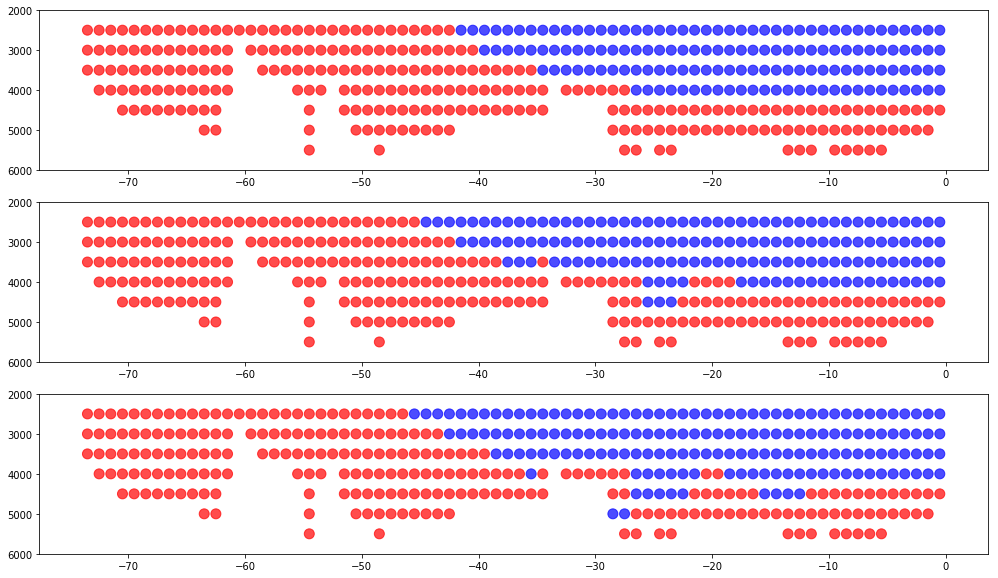

In [182]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(17, 10), facecolor='w')


line_lon = -30
min_lat, max_lat = -80, 80

# get data for N and S endmember calculation
tracers = ['salinity', 'phosphate', 'oxygen']
datast = dataFetcher()
datast.get_section('NS_section', line_lon, [min_lat, max_lat], tracers)
datast = ox_po4_convert(label_lat_ranges(datast))
datast = ox_po4_convert(datast,corrected_OP = True )

# get data for section to be analyzed
min_lat, max_lat = -80, 0
datast_S = dataFetcher()
datast_S.get_section('NS_section', line_lon, [min_lat, max_lat], tracers)
datast_S = ox_po4_convert(label_lat_ranges(datast_S))
datast_S = ox_po4_convert(datast_S,corrected_OP = True )

depths = [2500, 3000, 3500, 4000, 4500, 5000, 5500]
depth_trajs = {}
df_mixing_ratios = pd.DataFrame({'lat':[], 'depth':[], 'mixing_fraction':[], 'tracer': [], 'value': []})

tracers = ['salinity', 'po4_star', 'po4_star_c']
for im, trcr in enumerate(tracers):
    r = []
    b = []
    d_traj = {}
    for ij, dpth in enumerate(depths):
        # get N and S endmember values
        Atl = water_column(datast, 'traj', depth= dpth, tracer=trcr)
        Atl.get_endmembers('two_endmember')
        # find mixing ratios for limited scope trajectory using N and S endmembers
        Atl_S = water_column(datast_S, 'traj', depth= dpth, tracer=trcr)
        get_mixing_ratios(Atl.n_char, Atl.s_char, Atl_S)
        df_mixing_ratios = updated_df(df_mixing_ratios, Atl_S)
        d_traj[dpth] = Atl_S
        ax[im].scatter(Atl_S._ax_avgd, [dpth for ik in range(len(Atl_S._feat_data_avgd))], c = Atl_S.mixing_labels, alpha = .7, s=100)
        ax[im].set_ylim([6000,2000])
    
    depth_trajs[trcr] = d_traj
        

In [180]:
df_mixing_ratios[['depth', 'tracer', 'value','mixing_fraction']].groupby(['depth', 'tracer']).describe()

mixing_fraction                                          \
                            count      mean       std       min       25%   
depth  tracer                                                               
2500.0 po4_star              74.0  0.475127  0.325014  0.135992  0.209176   
       po4_star_c            74.0  0.445436  0.345527  0.076138  0.158236   
       salinity              74.0  0.520678  0.342673  0.141613  0.184641   
3000.0 po4_star              73.0  0.496409  0.329473  0.134769  0.209576   
       po4_star_c            73.0  0.466572  0.349601  0.072015  0.153736   
       salinity              73.0  0.512015  0.373561  0.129664  0.147365   
3500.0 po4_star              72.0  0.538648  0.316348  0.181993  0.205358   
       po4_star_c            72.0  0.510059  0.332995  0.117419  0.200320   
       salinity              72.0  0.552688  0.364084  0.120939  0.160581   
4000.0 po4_star              66.0  0.648920  0.185117  0.338430  0.477140   
       po4_star_c            66.0  0.629834  0.191351  0.346401  0.457931   
       salinity              66.0  0.644084  0.290634  0.172791  0.320764   
4500.0 po4_star              57.0  0.702798  0.156801  0.463706  0.568423   
       po4_star_c            57.0  0.671918  0.168012  0.399715  0.540597   
       salinity              57.0  0.765120  0.158227  0.593091  0.612439   
5000.0 po4_star              40.0  0.713482  0.102145  0.533759  0.657682   
       po4_star_c            40.0  0.684824  0.109233  0.476698  0.617896   
       salinity              40.0  0.798409  0.094490  0.669289  0.735445   
5500.0 po4_star              14.0  0.712806  0.093203  0.638571  0.661741   
       po4_star_c            14.0  0.694154  0.101681  0.591222  0.635835   
       salinity              14.0  0.862003  0.052438  0.821090  0.837022   

                                           value                       \
                        50%       75%  max count       mean       std   
depth  tracer                                                           
2500.0 po4_star    0.268312  0.853106  1.0  74.0   3.168289  0.355516   
       po4_star_c  0.227369  0.849612  1.0  74.0   3.138247  0.366634   
       salinity    0.386848  0.939433  1.0  74.0  34.813697  0.114336   
3000.0 po4_star    0.275910  0.893578  1.0  73.0   3.193277  0.354706   
       po4_star_c  0.230557  0.892151  1.0  73.0   3.162828  0.364998   
       salinity    0.356631  0.972253  1.0  73.0  34.806603  0.112865   
3500.0 po4_star    0.476387  0.868962  1.0  72.0   3.253832  0.337296   
       po4_star_c  0.426148  0.869554  1.0  72.0   3.223285  0.344238   
       salinity    0.556634  0.978237  1.0  72.0  34.785308  0.106878   
4000.0 po4_star    0.632624  0.833063  1.0  66.0   3.373438  0.265698   
       po4_star_c  0.600071  0.823429  1.0  66.0   3.342252  0.268454   
       salinity    0.678346  0.946440  1.0  66.0  34.747497  0.075899   
4500.0 po4_star    0.649588  0.816190  1.0  57.0   3.523910  0.132702   
       po4_star_c  0.622452  0.789688  1.0  57.0   3.492181  0.136618   
       salinity    0.639206  0.895639  1.0  57.0  34.705025  0.039459   
5000.0 po4_star    0.688497  0.778162  1.0  40.0   3.547664  0.094215   
       po4_star_c  0.668828  0.741504  1.0  40.0   3.515099  0.097193   
       salinity    0.756443  0.903871  1.0  40.0  34.696467  0.022928   
5500.0 po4_star    0.680854  0.740770  1.0  14.0   3.548457  0.089361   
       po4_star_c  0.689947  0.709388  1.0  14.0   3.524324  0.094213   
       salinity    0.842696  0.855023  1.0  14.0  34.694325  0.012017   

                                                                          
                         min        25%        50%        75%        max  
depth  tracer                                                             
2500.0 po4_star     2.797327   2.877378   2.942065   3.581740   3.742420  
       po4_star_c   2.746390   2.833503   2.906859   3.567112   3.726686  
       salinity    34.653767  34.673975  

In [181]:
# dictionaries by depth of mixing ratios for each tracer
sal_f = {key: np.asarray([depth_traj['salinity'][key].mixing_ratios[ik][0] for ik in range(len(depth_traj['salinity'][key].mixing_ratios))]) for key in depth_traj['salinity']}
po4_f = {key: np.asarray([depth_traj['po4_star'][key].mixing_ratios[ik][0] for ik in range(len(depth_traj['po4_star'][key].mixing_ratios))]) for key in depth_traj['po4_star']}       
po4_c_f = {key: np.asarray([depth_traj['po4_star_c'][key].mixing_ratios[ik][0] for ik in range(len(depth_traj['po4_star_c'][key].mixing_ratios))]) for key in depth_traj['po4_star_c']}       

print('min latitude:', min_lat, ', max latitude:', max_lat)
# comparing salinity fractions with PO4 fractions (uncorrected, corrected)
import scipy.stats as stats
print('depth', ' t (uncorr)','\t', 'p (uncorr)', '\t \t |','t (corr)','\t\t', 'p (corr)' )
for key in sal_f:
    tval,pval=stats.ttest_ind(sal_f[key], 
                          po4_f[key],
                          equal_var=True)
    tval1,pval1=stats.ttest_ind(sal_f[key], 
                          po4_c_f[key],
                          equal_var=True)
    print(key, ':', tval,'\t', pval, '\t |',tval1,'\t', pval1 )


min latitude: -80 , max latitude: 0
depth  t (uncorr) 	 p (uncorr) 	 	 | t (corr) 		 p (corr)
2500 : 0.829669498208 	 0.40808015899 	 | 1.33007221157 	 0.185568520913
3000 : 0.267686583848 	 0.78932361268 	 | 0.758866834634 	 0.449172572216
3500 : 0.247002601563 	 0.80526295844 	 | 0.733110398096 	 0.46469961799
4000 : -0.114020481217 	 0.909397463704 	 | 0.332695465137 	 0.739900068774
4500 : 2.11221857976 	 0.0368901672398 	 | 3.04890901055 	 0.00286632826863
5000 : 3.86012625197 	 0.000232268814184 	 | 4.97382717027 	 3.81922733642e-06
5500 : 5.22009666423 	 1.88164642015e-05 	 | 5.48950373032 	 9.27836001708e-06


#### North Atlantic (limited scope)

In [159]:
datast_N2.__dict__.keys()
tracers_psql = ['salinity', 'phosphate', 'oxygen']
min_lat, max_lat = 20, 80
line_lon = -30
datast_N = dataFetcher()
datast_N.get_section('NS_section', line_lon, [min_lat, max_lat], tracers_psql)
datast_N2 = dataFetcher()
datast_N2.get_section('NS_section', -29, [min_lat, max_lat], tracers_psql)


# datast_N._x = np.concatenate([datast_N._x, datast_N2._x])
# datast_N._y = np.concatenate([datast_N._y, datast_N2._y])
# datast_N._d = np.concatenate([datast_N._d, datast_N2._d])

# for key in datast_N.cluster_d.keys():
#         datast_N.cluster_d[key] = np.concatenate((datast_N.cluster_d[key], datast_N2.cluster_d[key]))
 

In [158]:
len(datast_N2.cluster_d['depth'])

14736

In [215]:
line_lon = -30
min_lat, max_lat = 0, 80

tracers_psql = ['salinity', 'phosphate', 'oxygen']
datast = dataFetcher()
datast.get_section('NS_section', line_lon, [min_lat, max_lat], tracers_psql)
datast = ox_po4_convert(label_lat_ranges(datast))
datast = ox_po4_convert(datast,corrected_OP = True )

min_lat, max_lat = 20, 80
# datast_N = dataFetcher()
# datast_N.get_section('NS_section', line_lon, [min_lat, max_lat], tracers)
# datast_N2 = dataFetcher()
# datast_N2.get_section('NS_section', -29, [min_lat, max_lat], tracers)

datast_N = ox_po4_convert(label_lat_ranges(datast_N2))
datast_N = ox_po4_convert(datast_N,corrected_OP = True )

depths = [2500, 3000, 3500, 4000, 4500, 5000, 5500]
depth_traj = {}

df_mixing_ratios = pd.DataFrame({'lat':[], 'depth':[], 'mixing_fraction':[], 'tracer': [], 'value':[]})

tracers = ['salinity', 'po4_star', 'po4_star_c']
for im, trcr in enumerate(tracers):
    r = []
    b = []
    d_traj = {}
    for ij, dpth in enumerate(depths):
        Atl = water_column(datast, 'traj', depth= dpth, tracer=trcr)
        Atl.get_endmembers('two_endmember') #checked: endmembers are the same for N and S sections
        Atl_N = water_column(datast_N, 'traj', depth= dpth, tracer=trcr)
        get_mixing_ratios(Atl.n_char, Atl.s_char, Atl_N)
        df_mixing_ratios = updated_df(df_mixing_ratios, Atl_N)
        d_traj[dpth] = Atl_N
        
    depth_traj[trcr] = d_traj

        

In [216]:
df_mixing_ratios[['depth', 'tracer','value', 'mixing_fraction']].groupby(['depth', 'tracer']).describe()

mixing_fraction                                          \
                            count      mean       std       min       25%   
depth  tracer                                                               
2500.0 po4_star              39.0  0.435513  0.232429  0.000000  0.298993   
       po4_star_c            39.0  0.439375  0.231340  0.000000  0.304789   
       salinity              39.0  0.505955  0.341576  0.017048  0.150984   
3000.0 po4_star              31.0  0.458310  0.265880  0.070140  0.274112   
       po4_star_c            31.0  0.460537  0.264034  0.069900  0.279355   
       salinity              31.0  0.403417  0.165564  0.015155  0.290684   
3500.0 po4_star              25.0  0.503241  0.311836  0.090172  0.223085   
       po4_star_c            25.0  0.504771  0.310619  0.089685  0.230073   
       salinity              25.0  0.474140  0.203788  0.034647  0.380239   
4000.0 po4_star              13.0  0.821296  0.186347  0.423361  0.744001   
       po4_star_c            13.0  0.820994  0.186545  0.422670  0.743487   
       salinity              13.0  0.363785  0.079617  0.228737  0.294070   
4500.0 po4_star              11.0  0.324648  0.249432  0.011885  0.144548   
       po4_star_c            11.0  0.323572  0.251348  0.008642  0.141927   
       salinity              11.0  0.300166  0.086299  0.098056  0.255732   
5000.0 po4_star              10.0  0.613510  0.213852  0.247248  0.463470   
       po4_star_c            10.0  0.613479  0.214328  0.246382  0.463718   
       salinity              10.0  0.269196  0.156185  0.062719  0.129799   
5500.0 po4_star               5.0  0.709341  0.038788  0.655058  0.681262   
       po4_star_c             5.0  0.709011  0.038571  0.654709  0.681510   
       salinity               5.0  0.035213  0.031807  0.000000  0.008209   

                                                value                       \
                        50%       75%       max count       mean       std   
depth  tracer                                                                
2500.0 po4_star    0.394243  0.498511  0.891308  39.0   2.763135  0.061317   
       po4_star_c  0.402516  0.502591  0.891366  39.0   2.780920  0.060896   
       salinity    0.516002  0.828567  0.996584  39.0  34.958461  0.020026   
3000.0 po4_star    0.328220  0.661892  0.926748  31.0   2.787824  0.074822   
       po4_star_c  0.333923  0.662451  0.926204  31.0   2.805243  0.074266   
       salinity    0.444996  0.526949  0.646484  31.0  34.943328  0.007376   
3500.0 po4_star    0.454444  0.820101  1.000000  25.0   2.826138  0.090881   
       po4_star_c  0.458080  0.820243  1.000000  25.0   2.843132  0.090571   
       salinity    0.532442  0.629444  0.700817  25.0  34.924293  0.009996   
4000.0 po4_star    0.900751  0.958891  1.000000  13.0   2.901438  0.104435   
       po4_star_c  0.900555  0.958729  1.000000  13.0   2.917911  0.104558   
       salinity    0.380949  0.420831  0.475483  13.0  34.902712  0.002842   
4500.0 po4_star    0.230634  0.533748  0.694427  11.0   2.981212  0.019237   
       po4_star_c  0.228439  0.533576  0.696620  11.0   2.997778  0.019310   
       salinity    0.321586  0.364759  0.395763  11.0  34.892566  0.000939   
5000.0 po4_star    0.648626  0.770358  0.938948  10.0   2.992542  0.035893   
       po4_star_c  0.648293  0.770741  0.940572  10.0   3.009070  0.036093   
       salinity    0.254491  0.380753  0.508903  10.0  34.886763  0.001996   
5500.0 po4_star    0.734513  0.735286  0.740587   5.0   3.012595  0.008069   
       po4_star_c  0.734256  0.735191  0.739391   5.0   3.029315  0.008060   
       salinity    0.037450  0.053503  0.076902   5.0  34.891320  0.000631   

                                                                          
                         min        25%        50%        75%        max  
depth  tracer                                                             
2500.0 po4_star     2.645810   2.727272   2.752343   2.779788   2.88317

In [217]:
print('min latitude:', min_lat, ', max latitude:', max_lat)
print('depth', ' t (uncorr)','\t', 'p (uncorr)', '\t \t |','t (corr)','\t\t', 'p (corr)' )

# comparing salinity fractions with PO4 fractions (uncorrected, corrected)
for depth in depths:
    tval,pval=stats.ttest_ind(df_mixing_ratios[(df_mixing_ratios['depth']== depth) & (df_mixing_ratios['tracer'] == 'po4_star')]['mixing_fraction'], df_mixing_ratios[(df_mixing_ratios['depth']== depth) & (df_mixing_ratios['tracer'] == 'salinity')]['mixing_fraction'], equal_var=True)
    tval1,pval1=stats.ttest_ind(df_mixing_ratios[(df_mixing_ratios['depth']== depth) & (df_mixing_ratios['tracer'] == 'po4_star_c')]['mixing_fraction'], df_mixing_ratios[(df_mixing_ratios['depth']== depth) & (df_mixing_ratios['tracer'] == 'salinity')]['mixing_fraction'], equal_var=True)
    print(depth, ':', tval,'\t', pval, '\t |',tval1,'\t', pval1 )

min latitude: 20 , max latitude: 80
depth  t (uncorr) 	 p (uncorr) 	 	 | t (corr) 		 p (corr)
2500 : -1.06475920366 	 0.290356097606 	 | -1.00788040345 	 0.316710063211
3000 : 0.975790732515 	 0.333086079762 	 | 1.02047770098 	 0.311599105615
3500 : 0.390588124267 	 0.697829868893 	 | 0.412258016919 	 0.68198577184
4000 : 8.1403181282 	 2.31673852123e-08 	 | 8.12763406335 	 2.38213637297e-08
4500 : 0.307642558538 	 0.761535098473 	 | 0.292106325075 	 0.773213892354
5000 : 4.11162639751 	 0.000655057059386 	 | 4.10528677547 	 0.000664360844924
5500 : 30.0508239378 	 1.6314601517e-09 	 | 30.137131758 	 1.59474314354e-09


Initially, I thought that performance would improve by limiting the scope to areas that do not included equitorial upwelling.  Upon further consideration, I thought sample size may play a role, but adding in a second line of longitude (e.g. -30 and -29) did not increase p values.  

I also checked for errors in the calculation of the limited scope experiments, but the mixing ratios are the same as those calculated for the corresponding latitudes in the pole to pole trajectory. 


## Graveyard

In [61]:
tracers = ['phosphate', 'oxygen', 'nitrate']
tracer_string = ','.join(tracers)
dataset_NA = dataFetcher()
dataset_NA.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE latitude > 60 and longitude < 15 and longitude >-70 and depth>=3000'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers, tracers, 'longitude', 'latitude')
df_NAtl = pd.DataFrame(dataset_NA.cluster_d)
df_NAtl['label'] = ['NAtl' for ik in range(len(df_NAtl))]

In [62]:
dataset_SA = dataFetcher()
dataset_SA.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE latitude <-60 and longitude < 15 and longitude >-70 and depth>=4000'.format(tracer_string),['latitude', 'longitude', 'depth']+ tracers, tracers, 'longitude', 'latitude')
df_SAtl = pd.DataFrame(dataset_SA.cluster_d)
df_SAtl['label'] = ['SO' for ik in range(len(df_SAtl))]

In [89]:
df_SNAtl = pd.concat([df_NAtl, df_SAtl])
df_SNAtl['oxygen'] = df_SNAtl['oxygen']*44.661

(0, 3)

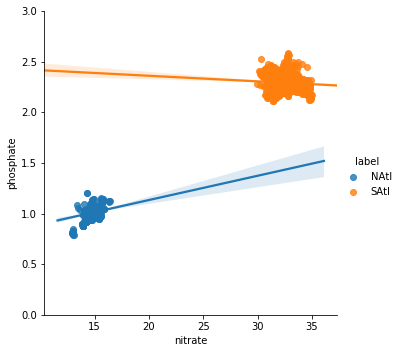

In [69]:
fig = sns.lmplot(x ='nitrate', y= 'phosphate', data = df_SNAtl, hue = 'label')
# sns.lmplot(x ='oxygen', y= 'phosphate', data = df_SAtl, ax = fig)
plt.ylim([0, 3])

(0, 3)

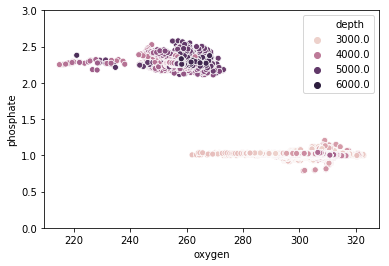

In [91]:
fig = sns.scatterplot(x ='oxygen', y= 'phosphate', data = df_SNAtl, hue = 'depth')
# sns.lmplot(x ='oxygen', y= 'phosphate', data = df_SAtl, ax = fig)
plt.ylim([0, 3])

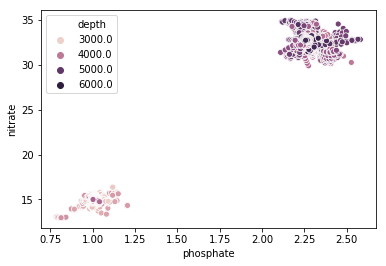

In [68]:
fig = sns.scatterplot(x ='phosphate', y= 'nitrate', data = df_SNAtl, hue = 'depth')
# sns.lmplot(x ='oxygen', y= 'phosphate', data = df_SAtl, ax = fig)


In [8]:
depth_traj['po4_star'][2500].mixing_ratios[0]

array([ 0.92828991,  0.07171009])

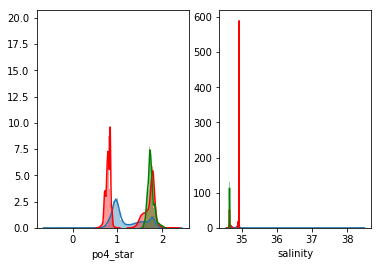

In [176]:
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
sns.distplot(df_Atl.po4_star, norm_hist = True, ax = ax)
sns.distplot(df_Atl[df_Atl['latitude']> 60].po4_star, norm_hist = False, ax = ax, color = 'red')
sns.distplot(df_Atl[(df_Atl['latitude']> -70) &(df_Atl['latitude']<-45) &(df_Atl['depth']>3000)].po4_star, norm_hist =True, ax = ax, color = 'red')
sns.distplot(df_Atl[(df_Atl['latitude']< -70)].po4_star, norm_hist = True, ax = ax, color = 'green')
ax1 = fig.add_subplot(1,2,2)
sns.distplot(df_Atl.salinity, norm_hist = False, ax = ax1)
sns.distplot(df_Atl[df_Atl['latitude']> 60].salinity, norm_hist = False, ax = ax1, color = 'red')
sns.distplot(df_Atl[(df_Atl['latitude']> -70) &(df_Atl['latitude']<-45)].salinity, norm_hist =False, ax = ax1, color = 'red')
sns.distplot(df_Atl[df_Atl['latitude']< -70].salinity, norm_hist = False, ax = ax1, color = 'green')


(34.5, 35.1)

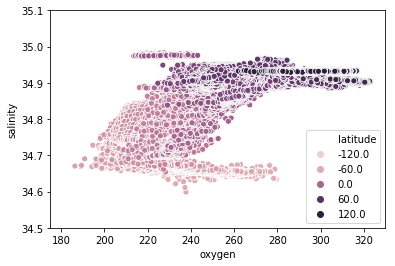

In [178]:
sns.scatterplot(x ='oxygen', y= 'salinity', data = df_Atl, hue = 'latitude', hue_norm=(-90, 90))
plt.ylim([34.5,35.1])
# plt.xlim([0, 2.5])

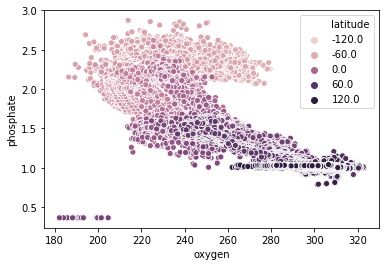

In [180]:
sns.scatterplot(x ='oxygen', y= 'phosphate', data = df_Atl, hue = 'latitude', hue_norm=(-90, 90))

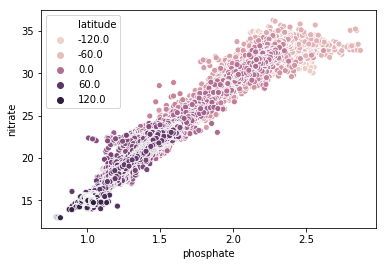

In [38]:
sns.scatterplot(x ='phosphate', y= 'nitrate', data = df_Atl, hue = 'latitude')

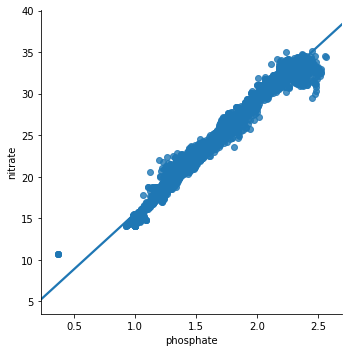

In [88]:
fig = sns.lmplot(x ='phosphate', y= 'nitrate', data = df_Atl)
# sns.lmplot(x ='oxygen', y= 'phosphate', data = df_SAtl, ax = fig)
# plt.ylim([0, 3])

(0.5, 3.5)

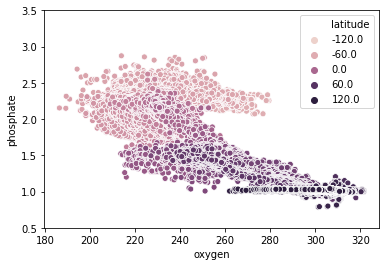

In [66]:
sns.scatterplot(x ='oxygen', y= 'phosphate', data = df_Atl, hue = 'latitude', hue_norm=(-90, 90))
plt.ylim([0.5,3.5])

(0, 2.5)

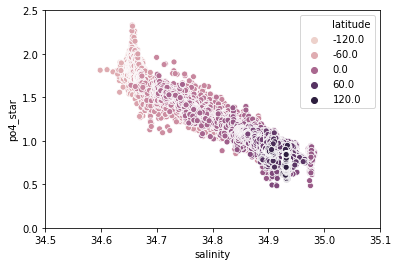

In [37]:
sns.scatterplot(x ='salinity', y= 'po4_star', data = df_Atl, hue = 'latitude', hue_norm=(-90, 90))
plt.xlim([34.5,35.1])
plt.ylim([0, 2.5])

(0.3, 3)

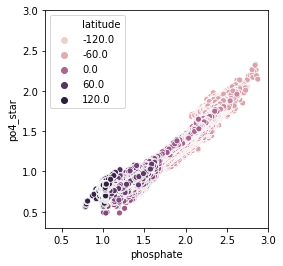

In [81]:
fig = plt.figure(figsize= (4,4))
fig.add_subplot(111)
sns.scatterplot(x ='phosphate', y= 'po4_star', data = df_Atl, hue = 'latitude', hue_norm=(-90, 90))
plt.xlim([.3, 3])
plt.ylim([.3, 3])

(34.5, 35.2)

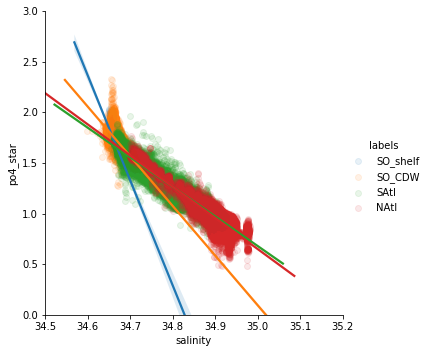

In [83]:
fig = sns.lmplot(x ='salinity', y= 'po4_star', data = df_Atl, hue = 'labels', scatter_kws={'alpha':0.1})
plt.ylim([0, 3])
plt.xlim([34.5, 35.2])

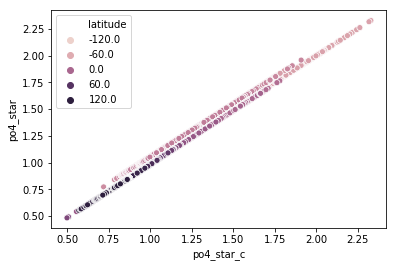

In [42]:
sns.scatterplot(x ='po4_star_c', y= 'po4_star', data = df_Atl, hue = 'latitude', hue_norm=(-90, 90))

(34.5, 35.2)

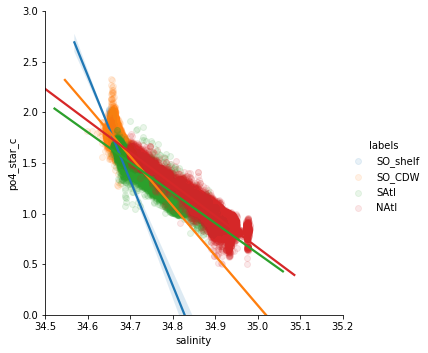

In [43]:
fig = sns.lmplot(x ='salinity', y= 'po4_star_c', data = df_Atl, hue = 'labels', scatter_kws={'alpha':0.1})
plt.ylim([0, 3])
plt.xlim([34.5, 35.2])